In [1]:
from torchvision.models import resnet50, ResNet50_Weights

from torchvision.datasets import ImageFolder, CIFAR100
import random
import time
import numpy as np
from PIL import Image
from copy import deepcopy
#import cpuinfo
import subprocess


import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
plt.style.use('fivethirtyeight')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
from Lec11ImageStuff import DownloadRPS, plotRPSbatch, plotCIFAR10batch
from Lec11sbs import StepByStep, CNN2layer
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
from torchvision.transforms import Compose, ToTensor, Normalize, ToPILImage,\
                                   Resize, CenterCrop, RandomResizedCrop

In [3]:
def FreezeModel(model):
    for par in model.parameters():
        par.requires_grad=False         # Will no longer learn this parameter

       
def PreprocessedDataset(model, loader, device=None):
    if device is None:  
        device = next(model.parameters()).device
        features = None
        labels = None
 
    for i, (x, y) in enumerate(loader):
        model.eval()
        output = model(x.to(device))
        if i == 0:
            features = output.detach().cpu()
            y = ((y - 1) // 5 + 1).to(torch.int64)
            labels = y.cpu()
        else:
            features = torch.cat(
                [features, output.detach().cpu()])
            y = ((y - 1) // 5 + 1).to(torch.int64)
            labels = torch.cat([labels, y.cpu()])

    dataset = TensorDataset(features, labels)
    return dataset


batch_size=128
CIFAR10NUMTRAIN=50000
CIFAR10NUMTEST=10000
normalizer=Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# Original RPS dataset images are 300x300 (3 channel)
# We need to convert them to 224x224. 

CIFAR100transform    = Compose( [Resize(224), ToTensor(), normalizer ])

CIFAR100trainset     = CIFAR100(root='./data', train=True, download=True, 
                              transform=CIFAR100transform)

CIFAR100trainloader  = DataLoader(CIFAR100trainset, batch_size=batch_size, 
                                 shuffle=True)

CIFAR100testset           = CIFAR100(root='./data', train=False, download=True, 
                                   transform=CIFAR100transform)
CIFAR100testloader   = DataLoader(CIFAR100testset, batch_size=batch_size, 
                                 shuffle=False)
CIFAR100classes = ['aquatic mammals',
'fish',
'flowers',
'food',
'fruit and vegetables',
'household electrical devices',
'household furniture',
'insects',
'large carnivores',
'large man-made outdoor things',
'large natural outdoor scenes',
'large omnivores and herbivores',
'medium-sized mammals',
'non-insect invertebrates',
'people',
'reptiles',
'small',
'trees',
'vehicles 1',
'vehicles 2']



Files already downloaded and verified
Files already downloaded and verified


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pretrained_resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
for name, param in pretrained_resnet.named_parameters():
    if param.requires_grad:
        print(name)

FreezeModel(pretrained_resnet)
pretrained_resnet.fc = nn.Sequential(nn.Linear(2048, 100))
pretrained_resnet.to(device)
for name, param in pretrained_resnet.named_parameters():
    if param.requires_grad:
        print(name)


conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.conv3.weight
layer1.0.bn3.weight
layer1.0.bn3.bias
layer1.0.downsample.0.weight
layer1.0.downsample.1.weight
layer1.0.downsample.1.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.conv3.weight
layer1.1.bn3.weight
layer1.1.bn3.bias
layer1.2.conv1.weight
layer1.2.bn1.weight
layer1.2.bn1.bias
layer1.2.conv2.weight
layer1.2.bn2.weight
layer1.2.bn2.bias
layer1.2.conv3.weight
layer1.2.bn3.weight
layer1.2.bn3.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.conv3.weight
layer2.0.bn3.weight
layer2.0.bn3.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.we

Training time: 95.94 seconds
Total number of parameters: 204900


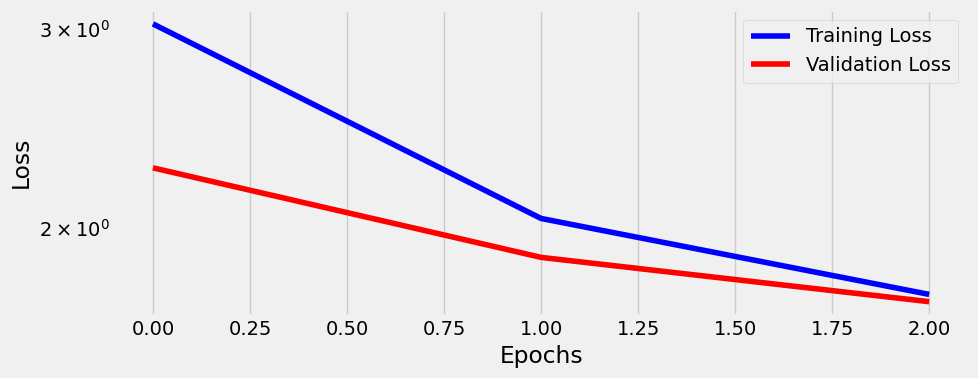

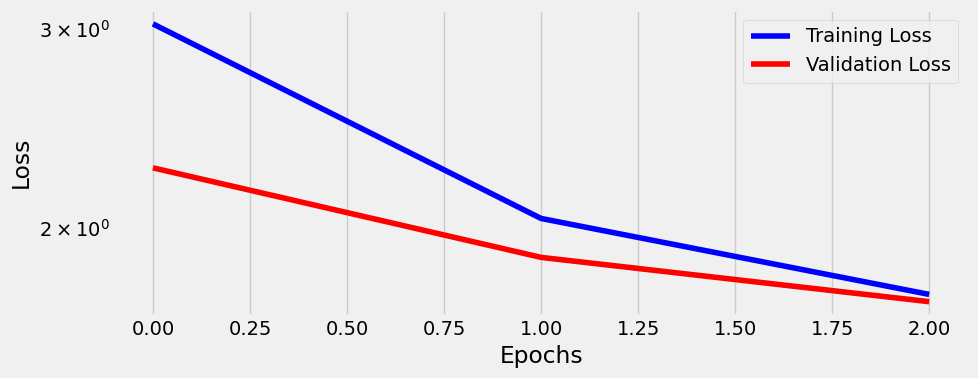

In [17]:
torch.manual_seed(20)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_resnet.parameters(), lr=3e-4)
sbsResnet = StepByStep(pretrained_resnet, loss_function, optimizer)
sbsResnet.set_loaders(CIFAR100trainloader, CIFAR100testloader)
t1 = time.time()
sbsResnet.train(3)
t2 = time.time()
TT = t2-t1
print(f"Training time: {TT/3:.2f} seconds")
parameters = sbsResnet.count_parameters()
print(f"Total number of parameters: {parameters}")
sbsResnet.plot_losses()

In [18]:
trainAccuracy=StepByStep.loader_apply(CIFAR100trainloader, sbsResnet.correct)
trainPredictions = trainAccuracy[:, 1]
trainCorrectPred = trainAccuracy[:, 0]
trainModelAccuracy = trainCorrectPred.sum()/trainPredictions.sum()*100.00
tpred=trainPredictions.sum()
tcorrect=trainCorrectPred.sum()
print(f"   TRAINING   ACCURACY:   {trainModelAccuracy:>5.1f}%",end='')
print(f"     {tpred:>4} predictions ({tcorrect:>5} correct ones)")

valAccuracy=StepByStep.loader_apply(CIFAR100testloader, sbsResnet.correct)
valPredictions = valAccuracy[:, 1]
valCorrectPred = valAccuracy[:, 0]
valModelAccuracy = valCorrectPred.sum()/valPredictions.sum()*100.00
vpred=valPredictions.sum()
vcorrect=valCorrectPred.sum()
print(f"   VALIDATION ACCURACY:   {valModelAccuracy:>5.1f}%",end='')
print(f"     {vpred:>4} predictions ({vcorrect:>5} correct ones)")

   TRAINING   ACCURACY:    62.2%     50000 predictions (31121 correct ones)
   VALIDATION ACCURACY:    55.8%     10000 predictions ( 5582 correct ones)


## Part B

In [36]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PB_Resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
FreezeModel(PB_Resnet)
PB_Resnet.fc = nn.Identity()
PB_Resnet.to(device)
#PPtrain_data = PreprocessedDataset(PB_Resnet, CIFAR100trainloader)
#PPval_data   = PreprocessedDataset(PB_Resnet, CIFAR100testloader)

#torch.save(PPtrain_data.tensors, 'CIFAR100preproc.pth')
#torch.save(PPval_data.tensors, 'CIFAR100val_preproc.pth')

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [4]:
x, y = torch.load('CIFAR100preproc.pth')
train_preproc = TensorDataset(x, y)
val_preproc = TensorDataset(*torch.load('CIFAR100val_preproc.pth'))


train_preproc_loader = DataLoader(train_preproc, batch_size=128, shuffle=True)
val_preproc_loader   = DataLoader(val_preproc, batch_size=128)

In [5]:
from dataset import NicelyFormatTime
top_one_train = []
top_one_test = []
top_five_test = []
class_head = nn.Sequential(nn.Linear(2048,100))
class_head.to(device)
torch.manual_seed(17)
loss_fn=nn.CrossEntropyLoss(reduction='mean')
optimizer=optim.Adam(class_head.parameters(), lr=3e-4)
# Our model to train the final layer
sbs_resnet_final=StepByStep(class_head, loss_fn,optimizer)
sbs_resnet_final.set_loaders(train_preproc_loader, val_preproc_loader)
sbs_resnet_final.to(device)
for Epochs in range(1,30):
    t1=time.time()
    sbs_resnet_final.train(Epochs)
    t2=time.time()
    TT=t2-t1                #Training Time
    TTPE=TT/float(Epochs)   #Training Time per epoch
    TT=NicelyFormatTime(TT)
    TTPE=NicelyFormatTime(TTPE)
    params=sbs_resnet_final.count_parameters()
    print(f"    TRAINING:             {Epochs} epoch{'s' if Epochs>1 else ''}")
    print(f"    TRAINING TIME:        {TT}  ({TTPE} per epoch)")
    trainAccuracy=StepByStep.loader_apply(train_preproc_loader, sbs_resnet_final.correct)
    trainPredictions = trainAccuracy[:, 1]
    trainCorrectPred = trainAccuracy[:, 0]
    trainModelAccuracy = trainCorrectPred.sum()/trainPredictions.sum()*100.00
    top_one_train.append(trainModelAccuracy)
    tpred=trainPredictions.sum()
    tcorrect=trainCorrectPred.sum()
    print(f"   TRAINING   ACCURACY:   {trainModelAccuracy:>5.1f}%",end='')
    print(f"     {tpred:>4} predictions ({tcorrect:>5} correct ones)")
    valAccuracy, top_5_val=StepByStep.loader_apply(val_preproc_loader, sbs_resnet_final.correct, top5=True)
    valPredictions = valAccuracy[:, 1]
    valCorrectPred = valAccuracy[:, 0]
    valModelAccuracy = valCorrectPred.sum()/valPredictions.sum()*100.00
    top_five_test.append(top_5_val)
    top_one_test.append(valModelAccuracy)
    vpred=valPredictions.sum()
    vcorrect=valCorrectPred.sum()
    print(f"   VALIDATION ACCURACY:   {valModelAccuracy:>5.1f}%",end='')
    print(f" TOP-5: {top_5_val:>5.1f}%")
    print(f"     {vpred:>4} predictions ({vcorrect:>5} correct ones)")
    print(80*'=')

    TRAINING:             1 epoch
    TRAINING TIME:         1883 ms   ( 1883 ms  per epoch)
   TRAINING   ACCURACY:    62.1%     50000 predictions (31030 correct ones)
   VALIDATION ACCURACY:    59.3% TOP-5:  87.3%
     10000 predictions ( 5928 correct ones)
    TRAINING:             2 epochs
    TRAINING TIME:          2.0 s   ( 1022 ms  per epoch)
   TRAINING   ACCURACY:    70.7%     50000 predictions (35355 correct ones)
   VALIDATION ACCURACY:    66.4% TOP-5:  91.0%
     10000 predictions ( 6642 correct ones)
    TRAINING:             3 epochs
    TRAINING TIME:          2.6 s   (867.4 ms per epoch)
   TRAINING   ACCURACY:    75.9%     50000 predictions (37946 correct ones)
   VALIDATION ACCURACY:    69.5% TOP-5:  92.3%
     10000 predictions ( 6948 correct ones)
    TRAINING:             4 epochs
    TRAINING TIME:          3.8 s   (962.2 ms per epoch)
   TRAINING   ACCURACY:    80.3%     50000 predictions (40157 correct ones)
   VALIDATION ACCURACY:    71.5% TOP-5:  93.1%
     1

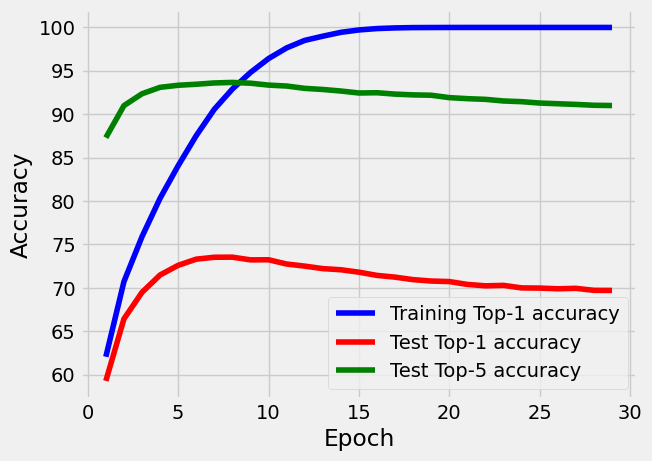

In [7]:
"""
X axis = epoch
Y axis = Training Top-1 accuracy (blue)
 Test Top-1 accuracy (red)
 Test Top-5 accuracy (green) 
 """
plt.figure()
plt.plot(range(1,30),top_one_train, label='Training Top-1 accuracy', color='blue')
plt.plot(range(1,30),top_one_test, label='Test Top-1 accuracy', color='red')
plt.plot(range(1,30),top_five_test, label='Test Top-5 accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('PB.png')

In [31]:

def PreprocessedDatasetC(model, loader, device=None):
    if device is None:  
        device = next(model.parameters()).device
        features = None
        labels = None
 
    for i, (x, y) in enumerate(loader):
        model.eval()
        output = model(x.to(device))
        if i == 0:
            features = output.detach().cpu()
            y = ((y - 1) // 5).clamp(0, 19)
            labels = y.cpu()
        else:
            features = torch.cat(
                [features, output.detach().cpu()])
            y = ((y - 1) // 5).clamp(0, 19)
            labels = torch.cat([labels, y.cpu()])

    dataset = TensorDataset(features, labels)
    return dataset

In [32]:
resnetPC = resnet50(weights=ResNet50_Weights.DEFAULT)
FreezeModel(resnetPC)
resnetPC.fc = nn.Identity()

PPtrain_data = PreprocessedDatasetC(resnetPC, CIFAR100trainloader)
PPval_data   = PreprocessedDatasetC(resnetPC, CIFAR100testloader)

torch.save(PPtrain_data.tensors, 'CIFAR100preproc_C.pth')
torch.save(PPval_data.tensors, 'CIFAR100val_preproc_C.pth')

# STEP 1: This is where our preprocessed train and val datasets are

In [5]:

x, y = torch.load('CIFAR100preproc_C.pth')
train_preproc = TensorDataset(x, y)
val_preproc = TensorDataset(*torch.load('CIFAR100val_preproc_C.pth'))


train_preproc_loader_20 = DataLoader(train_preproc, batch_size=128, shuffle=True)
val_preproc_loader_20   = DataLoader(val_preproc, batch_size=128)

In [43]:
data, target = next(iter(train_preproc_loader_20))
print(data.shape)
print(target.unique())

torch.Size([128, 2048])
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19])


In [26]:

data, target = next(iter(train_preproc_loader))
print(data.shape)
print(target.unique())

torch.Size([128, 2048])
tensor([ 0,  1,  2,  3,  4,  5,  9, 11, 12, 14, 15, 16, 19, 20, 21, 22, 23, 24,
        25, 27, 29, 30, 32, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 46, 48, 49,
        51, 52, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 67, 68, 69, 70,
        71, 72, 73, 75, 77, 78, 80, 82, 83, 85, 86, 89, 90, 91, 92, 93, 94, 95,
        96, 99])


In [6]:
from tqdm import tqdm
SuperFinal = nn.Sequential(nn.Linear(2048, 20))
loss1 = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(SuperFinal.parameters(), lr=3e-4)
sbsSuperFinal = StepByStep(SuperFinal, loss1, optimizer1)
sbsSuperFinal.set_loaders(train_preproc_loader_20, val_preproc_loader_20)
train_acc = []
val_acc = []
for epoch in tqdm(range(30)):
    sbsSuperFinal.train(epoch)
    trainAccuracy = StepByStep.loader_apply(train_preproc_loader_20, sbsSuperFinal.correct)
    trainPredictions = trainAccuracy[:, 1]
    trainCorrectPred = trainAccuracy[:, 0]
    trainModelAccuracy = trainCorrectPred.sum()/trainPredictions.sum()*100.00
    train_acc.append(trainModelAccuracy)
    valAccuracy = StepByStep.loader_apply(val_preproc_loader_20, sbsSuperFinal.correct)
    valPredictions = valAccuracy[:, 1]
    valCorrectPred = valAccuracy[:, 0]
    valModelAccuracy = valCorrectPred.sum()/valPredictions.sum()*100.00
    val_acc.append(valModelAccuracy)
    print(f"Epoch: {epoch+1} Train Accuracy: {trainModelAccuracy:.2f} Val Accuracy: {valModelAccuracy:.2f}")


  3%|██                                                            | 1/30 [00:02<01:02,  2.16s/it]

Epoch: 1 Train Accuracy: 4.09 Val Accuracy: 4.02


  7%|████▏                                                         | 2/30 [00:04<01:07,  2.40s/it]

Epoch: 2 Train Accuracy: 50.08 Val Accuracy: 48.65


 10%|██████▏                                                       | 3/30 [00:08<01:16,  2.85s/it]

Epoch: 3 Train Accuracy: 61.55 Val Accuracy: 59.14


 13%|████████▎                                                     | 4/30 [00:12<01:25,  3.30s/it]

Epoch: 4 Train Accuracy: 66.62 Val Accuracy: 63.03


 17%|██████████▎                                                   | 5/30 [00:17<01:37,  3.91s/it]

Epoch: 5 Train Accuracy: 70.03 Val Accuracy: 65.28


 20%|████████████▍                                                 | 6/30 [00:23<01:51,  4.63s/it]

Epoch: 6 Train Accuracy: 72.53 Val Accuracy: 66.53


 23%|██████████████▍                                               | 7/30 [00:29<01:59,  5.18s/it]

Epoch: 7 Train Accuracy: 74.41 Val Accuracy: 67.01


 27%|████████████████▌                                             | 8/30 [00:37<02:12,  6.03s/it]

Epoch: 8 Train Accuracy: 76.00 Val Accuracy: 67.41


 30%|██████████████████▌                                           | 9/30 [00:45<02:20,  6.69s/it]

Epoch: 9 Train Accuracy: 77.40 Val Accuracy: 67.72


 33%|████████████████████▎                                        | 10/30 [00:55<02:33,  7.69s/it]

Epoch: 10 Train Accuracy: 78.49 Val Accuracy: 67.73


 37%|██████████████████████▎                                      | 11/30 [01:05<02:43,  8.59s/it]

Epoch: 11 Train Accuracy: 79.55 Val Accuracy: 68.09


 40%|████████████████████████▍                                    | 12/30 [01:17<02:49,  9.41s/it]

Epoch: 12 Train Accuracy: 80.50 Val Accuracy: 67.74


 43%|██████████████████████████▍                                  | 13/30 [01:29<02:52, 10.15s/it]

Epoch: 13 Train Accuracy: 81.01 Val Accuracy: 67.30


 47%|████████████████████████████▍                                | 14/30 [01:42<02:59, 11.21s/it]

Epoch: 14 Train Accuracy: 81.72 Val Accuracy: 67.38


 50%|██████████████████████████████▌                              | 15/30 [01:58<03:06, 12.47s/it]

Epoch: 15 Train Accuracy: 82.36 Val Accuracy: 66.98


 53%|████████████████████████████████▌                            | 16/30 [02:14<03:09, 13.52s/it]

Epoch: 16 Train Accuracy: 82.90 Val Accuracy: 66.87


 57%|██████████████████████████████████▌                          | 17/30 [02:29<03:03, 14.12s/it]

Epoch: 17 Train Accuracy: 83.24 Val Accuracy: 66.61


 60%|████████████████████████████████████▌                        | 18/30 [02:47<03:02, 15.18s/it]

Epoch: 18 Train Accuracy: 83.80 Val Accuracy: 66.35


 63%|██████████████████████████████████████▋                      | 19/30 [03:03<02:51, 15.56s/it]

Epoch: 19 Train Accuracy: 84.09 Val Accuracy: 66.13


 67%|████████████████████████████████████████▋                    | 20/30 [03:23<02:47, 16.74s/it]

Epoch: 20 Train Accuracy: 84.56 Val Accuracy: 66.03


 70%|██████████████████████████████████████████▋                  | 21/30 [03:43<02:41, 17.92s/it]

Epoch: 21 Train Accuracy: 84.83 Val Accuracy: 65.70


 73%|████████████████████████████████████████████▋                | 22/30 [04:06<02:34, 19.26s/it]

Epoch: 22 Train Accuracy: 85.13 Val Accuracy: 65.34


 77%|██████████████████████████████████████████████▊              | 23/30 [04:29<02:22, 20.42s/it]

Epoch: 23 Train Accuracy: 85.41 Val Accuracy: 65.13


 80%|████████████████████████████████████████████████▊            | 24/30 [04:51<02:05, 20.97s/it]

Epoch: 24 Train Accuracy: 85.78 Val Accuracy: 65.07


 83%|██████████████████████████████████████████████████▊          | 25/30 [05:16<01:50, 22.16s/it]

Epoch: 25 Train Accuracy: 86.18 Val Accuracy: 64.74


 87%|████████████████████████████████████████████████████▊        | 26/30 [05:42<01:33, 23.29s/it]

Epoch: 26 Train Accuracy: 86.38 Val Accuracy: 64.51


 90%|██████████████████████████████████████████████████████▉      | 27/30 [06:05<01:09, 23.30s/it]

Epoch: 27 Train Accuracy: 86.60 Val Accuracy: 64.35


 93%|████████████████████████████████████████████████████████▉    | 28/30 [06:31<00:48, 24.13s/it]

Epoch: 28 Train Accuracy: 86.87 Val Accuracy: 64.19


 97%|██████████████████████████████████████████████████████████▉  | 29/30 [06:58<00:24, 24.98s/it]

Epoch: 29 Train Accuracy: 87.03 Val Accuracy: 64.03


100%|█████████████████████████████████████████████████████████████| 30/30 [07:26<00:00, 14.87s/it]

Epoch: 30 Train Accuracy: 87.25 Val Accuracy: 63.57


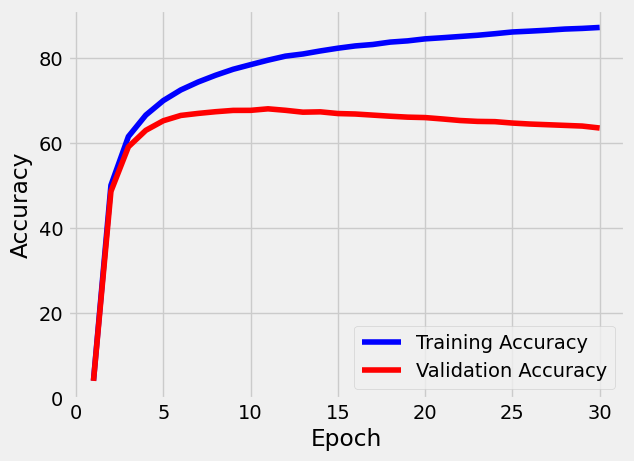

In [7]:
plt.figure()
plt.plot(range(1,31),train_acc, label='Training Accuracy', color='blue')
plt.plot(range(1,31),val_acc, label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('PC_SuperFinal.png')

In [8]:

SubFinal = nn.Sequential(nn.Linear(2048, 100))
loss2 = nn.CrossEntropyLoss() 
optimizer2 = optim.Adam(SubFinal.parameters(), lr=3e-4)
sbsSubFinal = StepByStep(SubFinal, loss2, optimizer2)
sbsSubFinal.set_loaders(train_preproc_loader, val_preproc_loader)
train_acc_2 = []
val_acc_2 = []
for epoch in tqdm(range(30)):
    sbsSubFinal.train(epoch)
    trainAccuracy = StepByStep.loader_apply(train_preproc_loader, sbsSubFinal.correct)
    trainPredictions = trainAccuracy[:, 1]
    trainCorrectPred = trainAccuracy[:, 0]
    trainModelAccuracy = trainCorrectPred.sum()/trainPredictions.sum()*100.00
    train_acc_2.append(trainModelAccuracy)
    valAccuracy = StepByStep.loader_apply(val_preproc_loader, sbsSubFinal.correct)
    valPredictions = valAccuracy[:, 1]
    valCorrectPred = valAccuracy[:, 0]
    valModelAccuracy = valCorrectPred.sum()/valPredictions.sum()*100.00
    val_acc_2.append(valModelAccuracy)
    print(f"Epoch: {epoch+1} Train Accuracy: {trainModelAccuracy:.2f} Val Accuracy: {valModelAccuracy:.2f}")


  3%|██                                                            | 1/30 [00:04<02:16,  4.69s/it]

Epoch: 1 Train Accuracy: 0.91 Val Accuracy: 0.70


  7%|████▏                                                         | 2/30 [00:10<02:24,  5.14s/it]

Epoch: 2 Train Accuracy: 62.04 Val Accuracy: 59.27


 10%|██████▏                                                       | 3/30 [00:16<02:33,  5.67s/it]

Epoch: 3 Train Accuracy: 70.65 Val Accuracy: 66.35


 13%|████████▎                                                     | 4/30 [00:23<02:43,  6.29s/it]

Epoch: 4 Train Accuracy: 75.87 Val Accuracy: 69.36


 17%|██████████▎                                                   | 5/30 [00:31<02:52,  6.90s/it]

Epoch: 5 Train Accuracy: 80.28 Val Accuracy: 71.41


 20%|████████████▍                                                 | 6/30 [00:40<03:00,  7.53s/it]

Epoch: 6 Train Accuracy: 84.00 Val Accuracy: 72.51


 23%|██████████████▍                                               | 7/30 [00:50<03:11,  8.32s/it]

Epoch: 7 Train Accuracy: 87.53 Val Accuracy: 73.27


 27%|████████████████▌                                             | 8/30 [01:01<03:26,  9.36s/it]

Epoch: 8 Train Accuracy: 90.51 Val Accuracy: 73.55


 30%|██████████████████▌                                           | 9/30 [01:14<03:35, 10.27s/it]

Epoch: 9 Train Accuracy: 92.88 Val Accuracy: 73.50


 33%|████████████████████▎                                        | 10/30 [01:27<03:46, 11.35s/it]

Epoch: 10 Train Accuracy: 94.82 Val Accuracy: 73.34


 37%|██████████████████████▎                                      | 11/30 [01:41<03:48, 12.02s/it]

Epoch: 11 Train Accuracy: 96.40 Val Accuracy: 73.22


 40%|████████████████████████▍                                    | 12/30 [01:56<03:53, 12.96s/it]

Epoch: 12 Train Accuracy: 97.63 Val Accuracy: 72.65


 43%|██████████████████████████▍                                  | 13/30 [02:12<03:57, 13.99s/it]

Epoch: 13 Train Accuracy: 98.49 Val Accuracy: 72.54


 47%|████████████████████████████▍                                | 14/30 [02:29<03:54, 14.66s/it]

Epoch: 14 Train Accuracy: 98.99 Val Accuracy: 72.26


 50%|██████████████████████████████▌                              | 15/30 [02:46<03:53, 15.57s/it]

Epoch: 15 Train Accuracy: 99.43 Val Accuracy: 72.14


 53%|████████████████████████████████▌                            | 16/30 [03:05<03:51, 16.52s/it]

Epoch: 16 Train Accuracy: 99.69 Val Accuracy: 71.80


 57%|██████████████████████████████████▌                          | 17/30 [03:25<03:46, 17.42s/it]

Epoch: 17 Train Accuracy: 99.85 Val Accuracy: 71.41


 60%|████████████████████████████████████▌                        | 18/30 [03:45<03:40, 18.40s/it]

Epoch: 18 Train Accuracy: 99.93 Val Accuracy: 71.25


 63%|██████████████████████████████████████▋                      | 19/30 [04:07<03:32, 19.28s/it]

Epoch: 19 Train Accuracy: 99.97 Val Accuracy: 70.99


 67%|████████████████████████████████████████▋                    | 20/30 [04:28<03:20, 20.00s/it]

Epoch: 20 Train Accuracy: 99.97 Val Accuracy: 70.75


 70%|██████████████████████████████████████████▋                  | 21/30 [04:51<03:07, 20.80s/it]

Epoch: 21 Train Accuracy: 99.98 Val Accuracy: 70.64


 73%|████████████████████████████████████████████▋                | 22/30 [05:13<02:50, 21.29s/it]

Epoch: 22 Train Accuracy: 99.98 Val Accuracy: 70.37


 77%|██████████████████████████████████████████████▊              | 23/30 [05:39<02:38, 22.58s/it]

Epoch: 23 Train Accuracy: 99.98 Val Accuracy: 70.20


 80%|████████████████████████████████████████████████▊            | 24/30 [06:04<02:20, 23.39s/it]

Epoch: 24 Train Accuracy: 99.98 Val Accuracy: 70.31


 83%|██████████████████████████████████████████████████▊          | 25/30 [06:31<02:01, 24.28s/it]

Epoch: 25 Train Accuracy: 99.98 Val Accuracy: 70.05


 87%|████████████████████████████████████████████████████▊        | 26/30 [06:57<01:39, 24.89s/it]

Epoch: 26 Train Accuracy: 99.98 Val Accuracy: 69.99


 90%|██████████████████████████████████████████████████████▉      | 27/30 [07:26<01:18, 26.03s/it]

Epoch: 27 Train Accuracy: 99.98 Val Accuracy: 69.93


 93%|████████████████████████████████████████████████████████▉    | 28/30 [07:54<00:53, 26.75s/it]

Epoch: 28 Train Accuracy: 99.98 Val Accuracy: 69.95


 97%|██████████████████████████████████████████████████████████▉  | 29/30 [08:24<00:27, 27.60s/it]

Epoch: 29 Train Accuracy: 99.98 Val Accuracy: 69.78


100%|█████████████████████████████████████████████████████████████| 30/30 [08:55<00:00, 17.85s/it]

Epoch: 30 Train Accuracy: 99.98 Val Accuracy: 69.67


In [34]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['beaver', 'elephant', 'peppers', 'bear', 'dolphin', 'roses']
        self.class_idx = [1, 59, 25, 41,2, 13 ]

    def __len__(self):
        return len(self.classes) *10  # 10 images per class

    def __getitem__(self, idx):
        class_idx = idx // 10
        class_name = self.classes[class_idx]
        image_name = f"{class_name}{idx % 10 +1}.jpeg"
        image_path = os.path.join(self.root_dir, image_name)
        if os.path.exists(image_path):
            image = Image.open(image_path)
        else:
            image_name = f"{class_name}{idx % 10 +1}.jpg"
            image_path = os.path.join(self.root_dir, image_name)
            image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        return image, self.class_idx[class_idx]

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((32, 32)),         # Resize to 32x32 pixels
    transforms.ToTensor()                # Convert to tensor
])

# Create an instance of your custom dataset
root_dir = './NEW_CIFAR/'
custom_dataset = CustomDataset(root_dir, transform=transform)

# Create a DataLoader to iterate through the dataset
batch_size = 16
data_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)

torch.Size([16, 3, 32, 32])


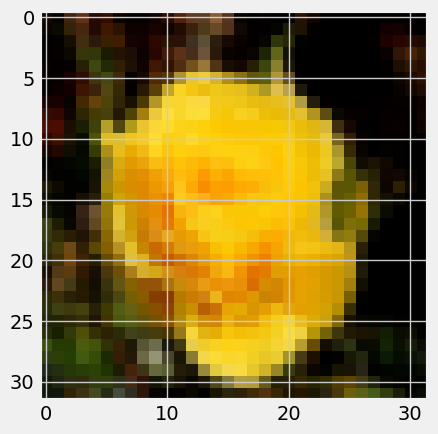

tensor(13)


In [35]:
data, target = next(iter(data_loader))
print(data.shape)
plt.imshow(data[0].permute(1, 2, 0))
plt.show()
print(target[0])

In [37]:
#Plug these two trained parallel (SuperFinal and SubFinal)layers back into ResNet-50 and call this new model BrainNet.
#BrainNet now has all of the frozen stuff, which feeds the data into two parallel final layers,
#which output two separate outputs (first 20 outputs, next 100 outputs).

class BrainNet(nn.Module):
    def __init__(self, SuperFinal, SubFinal, resnet):
        super(BrainNet, self).__init__()
        self.SuperFinal = SuperFinal
        self.SubFinal = SubFinal
        self.resnet = resnet

    def forward(self, x):
        x = self.resnet(x)
        x1 = self.SuperFinal(x)
        x2 = self.SubFinal(x)
        return x1, x2

In [69]:
## Test it with the new dataset
root_dir = './NEW_CIFAR/'
custom_dataset = CustomDataset(root_dir, transform=transform)
batch_size = 16
data_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnetPD = resnet50(weights=ResNet50_Weights.DEFAULT)
resnetPD.fc = nn.Identity()
resnetPD.to(device)
brain_net = BrainNet(SuperFinal, SubFinal, resnetPD)
#Report your results with a 5-column table, where the columns are:
#1) Original label of the image
#2) Super-class reported by BrainNet
#3) Super-class confidence (at what percentage did it report it)
#4) Sub-class reported by BrainNet
#5) Sub-class confidence (at what percentage did it report it)
table_data = []
sigm = nn.Softmax()
for data, target in iter(data_loader):
    data = data.to(device)
    target = target.to(device)
    output1, output2 = brain_net(data)
    target1 = ((target - 1) // 5).clamp(0, 19)
    #confidence of output1
    prbs1 = F.softmax(output1, dim=1)
    predicted_class1 = torch.argmax(prbs1, dim=1)
    conf1 = prbs1[torch.arange(len(predicted_class1)), predicted_class1]
    #confidence of output2
    prbs2 = F.softmax(output2, dim=1)
    predicted_class2 = torch.argmax(prbs2, dim=1)
    conf2 = prbs2[torch.arange(len(predicted_class2)), predicted_class2]
    for i in range(len(target)):
        row = [
            output1[i].argmax(dim=0).item(),
            conf1[i].item(),
            target1[i].item(),
            output2[i].argmax(dim=0).item(),
            conf2[i].item(),
            target[i].item()
        ]
        table_data.append(row)

table_latex = "\\begin{table}[ht]\n"
table_latex += "\\centering\n"
table_latex += "\\begin{tabular}{|c|c|c|c|c|c|}\n"
table_latex += "\\hline\n"
table_latex += "Output 1 & Confidence 1 & Target 1 & Output 2 & Confidence 2 & Target \\\\\n"
table_latex += "\\hline\n"

for row in table_data:
    formatted_row = [f"{val:.2f}" if isinstance(val, (float)) else str(val) for val in row]
    table_latex += " & ".join(formatted_row) + " \\\\\n"

table_latex += "\\hline\n"
table_latex += "\\end{tabular}\n"
table_latex += "\\caption{Your table caption here.}\n"
table_latex += "\\label{tab:your_table_label}\n"
table_latex += "\\end{table}\n"

print(table_latex)


\begin{table}[ht]
\centering
\begin{tabular}{|c|c|c|c|c|c|}
\hline
Output 1 & Confidence 1 & Target 1 & Output 2 & Confidence 2 & Target \\
\hline
19 & 1.00 & 2 & 13 & 1.00 & 13 \\
16 & 0.98 & 4 & 83 & 1.00 & 25 \\
14 & 1.00 & 0 & 71 & 1.00 & 2 \\
11 & 0.73 & 0 & 45 & 1.00 & 2 \\
3 & 0.73 & 0 & 41 & 0.98 & 2 \\
10 & 0.92 & 0 & 63 & 0.48 & 1 \\
2 & 0.93 & 8 & 73 & 0.78 & 41 \\
15 & 1.00 & 8 & 10 & 1.00 & 41 \\
11 & 1.00 & 4 & 77 & 0.77 & 25 \\
5 & 0.20 & 11 & 35 & 0.33 & 59 \\
8 & 0.64 & 0 & 4 & 0.54 & 1 \\
13 & 0.96 & 2 & 51 & 1.00 & 13 \\
19 & 1.00 & 2 & 54 & 1.00 & 13 \\
11 & 0.50 & 11 & 63 & 0.82 & 59 \\
12 & 1.00 & 2 & 95 & 1.00 & 13 \\
8 & 0.98 & 0 & 12 & 1.00 & 2 \\
15 & 0.58 & 0 & 45 & 1.00 & 1 \\
11 & 0.42 & 2 & 57 & 0.98 & 13 \\
6 & 0.72 & 0 & 38 & 1.00 & 2 \\
5 & 0.63 & 0 & 57 & 0.97 & 1 \\
3 & 0.95 & 4 & 46 & 0.99 & 25 \\
9 & 0.74 & 0 & 60 & 1.00 & 2 \\
8 & 0.92 & 4 & 41 & 1.00 & 25 \\
3 & 0.60 & 11 & 36 & 0.98 & 59 \\
10 & 0.91 & 0 & 7 & 0.99 & 2 \\
9 & 1.00 & 0 & 65 & 1.00

In [ ]:
plt.figure()
plt.plot(range(1,31),train_acc, label='SuperFinal: training accuracy', marker='o')
plt.plot(range(1,31),val_acc, label='SuperFinal: validation accuracy', marker='o')
plt.plot(range(1,31),train_acc_2, label='SubFinal: training accuracy', marker='o')
plt.plot(range(1,31),val_acc_2, label='SubFinal: validation accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('SuperFinal_SubFinal.png')

In [70]:
# save latex table to file
with open("table.tex", "w") as f:
    f.write(table_latex)